In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from IPython.core.display import display
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from multi_imbalance.datasets import load_datasets
from multi_imbalance.resampling.SOUP import SOUP
from multi_imbalance.resampling.MDO import MDO
from multi_imbalance.resampling.GlobalCS import GlobalCS

from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from multi_imbalance.resampling.spider import SPIDER3

import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
datasets = load_datasets()

In [3]:
for dataset_name, dataset in datasets.items():
    print(dataset_name, Counter(dataset.target))

1czysty-cut Counter({0: 840, 2: 240, 1: 120})
2delikatne-cut Counter({0: 840, 2: 240, 1: 120})
3mocniej-cut Counter({0: 840, 2: 240, 1: 120})
4delikatne-bezover-cut Counter({0: 840, 2: 240, 1: 120})
balance-scale Counter({2: 288, 1: 288, 0: 49})
cleveland Counter({0: 164, 1: 55, 2: 36, 3: 35, 4: 13})
cleveland_v2 Counter({0: 219, 1: 36, 2: 35, 3: 13})
cmc Counter({0: 629, 2: 511, 1: 333})
dermatology Counter({0: 112, 2: 72, 1: 61, 4: 52, 3: 49, 5: 20})
glass Counter({1: 76, 0: 70, 3: 29, 5: 17, 2: 13, 4: 9})
hayes-roth Counter({0: 65, 1: 64, 2: 31})
new_ecoli Counter({0: 145, 1: 77, 4: 52, 2: 37, 3: 25})
new_led7digit Counter({3: 108, 5: 99, 0: 98, 2: 94, 4: 52, 1: 49})
new_vehicle Counter({1: 429, 0: 218, 2: 199})
new_winequality-red Counter({0: 681, 1: 638, 2: 199, 3: 81})
new_yeast Counter({0: 463, 1: 429, 8: 244, 7: 168, 6: 51, 5: 44, 4: 35, 3: 30, 2: 20})
thyroid-newthyroid Counter({0: 150, 1: 35, 2: 30})


In [4]:
maj_int_min = {
    "1czysty-cut": {'maj': [0],'int': [2],'min': [1]}, 
    "2delikatne-cut": {'maj': [0],'int': [2],'min': [1]},
    "3mocniej-cut": {'maj': [0],'int': [2],'min': [1]},
    "4delikatne-bezover-cut": {'maj': [0],'int': [2],'min': [1]},
    "balance-scale": {'maj': [2, 1],'int': [],'min': [0]},
    "cleveland": {'maj': [0],'int': [1],'min': [2, 3, 4]},
    "cleveland_v2": {'maj': [0],'int': [],'min': [1,2,3]},
    "cmc": {'maj': [0, 2],'int': [],'min': [1]},
    "dermatology": {'maj': [0,],'int': [2, 1, 4, 3],'min': [5]},
    "glass": {'maj': [1, 0],'int': [3],'min': [5, 2, 4]},
    "hayes-roth": {'maj': [],'int': [],'min': [0,1, 2]},
    "new_ecoli": {'maj': [0],'int': [1,4],'min': [2, 3]},
    "new_led7digit": {'maj': [3, 5, 0, 2,4,1],'int': [],'min': []},
    "new_vehicle": {'maj': [1],'int': [],'min': [0, 2]},
    "new_winequality-red": {'maj': [0, 1],'int': [2],'min': [3]},
    "new_yeast": {'maj': [0, 1],'int': [8, 7],'min': [6,5,4,3,2]},
    "thyroid-newthyroid": {'maj': [0],'int': [],'min': [1,2]}
}

In [5]:
def calc_cost_matrix1(dataset_name):
    #imbalance ratio
    cost = np.ones((no_classes, no_classes))
    element_count = Counter(datasets[dataset_name].target)
    cardinality_pairs = list(element_count.items())
    cost = np.zeros((len(cardinality_pairs), len(cardinality_pairs)))

    for idx1, card1 in cardinality_pairs:
        for idx2, card2 in cardinality_pairs:
            cost[idx1, idx2] = card1/card2

    np.fill_diagonal(cost, 0)
    return cost

def calc_cost_matrix(dataset_name):
    #default
    no_classes = np.unique(datasets[dataset_name].target).size
    cost = np.ones((no_classes, no_classes))
    np.fill_diagonal(cost, 0)
    return cost

def calc_cost_matrix2(dataset_name):
    #default
    cost = np.ones((no_classes, no_classes))
    np.fill_diagonal(cost, 0)
    #print(cost)
    #Counter({1: 76, 0: 70, 3: 29, 5: 17, 2: 13, 4: 9})
    #                 0   1   2   3   4   5
    return np.array([[0., 1., 1., 1., 5., 1.],
                     [1., 0., 1., 1., 5., 1.],
                     [1., 1., 0., 1., 5., 1.],
                     [1., 1., 1., 0., 5., 1.],
                     [5., 5., 5., 5., 0., 5.],
                     [1., 1., 1., 1., 5., 0.]])

In [7]:
test()

glass


'G-MEAN'

,base,global,mdo,soup,spider
glass,0.506,0.634,0.615,0.649,0.583


'ACC'

,base,global,mdo,soup,spider
glass,0.673,0.662,0.636,0.583,0.55


'MEAN G-MEAN'

base      0.506
global    0.634
mdo       0.615
soup      0.649
spider    0.583
dtype: float64

'MEAN ACC'

base      0.673
global    0.662
mdo       0.636
soup      0.583
spider    0.550
dtype: float64

In [6]:
def test():
    np.random.seed(0)

    datasets = load_datasets()
    results_g_mean = dict()
    results_acc = dict()

    for dataset_name, dataset_values in datasets.items():
        if dataset_name != 'glass':
            continue
        print(dataset_name)

        X, y = dataset_values.data, dataset_values.target

        if len(X)>1000:
            continue

        results_g_mean[dataset_name]=dict()
        results_acc[dataset_name]=dict()

        for resample in ['base','global', 'soup', 'mdo', 'spider']:

            skf = StratifiedKFold(n_splits=4, random_state=0)
            acc, g_mean = list(),list()
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                error_flag = False
                clf_tree = DecisionTreeClassifier(random_state=0)

                if resample == 'base':
                    X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='soup':
                    soup = SOUP()
                    X_train_resampled, y_train_resampled = soup.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='global':
                    global_cs = GlobalCS()
                    X_train_resampled, y_train_resampled = global_cs.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='smote':
                    try:
                        smote = SMOTE()
                        X_train_resampled, y_train_resampled = smote.fit_sample(np.copy(X_train), np.copy(y_train))
                    except Exception as e:
                        error_flag = True
                        print(resample, dataset_name, e)
                        X_train_resampled, y_train_resampled = X_train, y_train
                elif resample=='mdo':
                    mdo = MDO(k=9, k1_frac=0, seed=0)
                    X_train_resampled, y_train_resampled = mdo.fit_transform(np.copy(X_train), np.copy(y_train))
                elif resample=='spider':
                    cost = calc_cost_matrix(dataset_name)
                    clf = SPIDER3(k=5, cost=cost, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'])
                    X_train_resampled, y_train_resampled = clf.fit_transform(X_train.astype(np.float64), y_train)

                clf_tree.fit(X_train_resampled, y_train_resampled)
                y_pred = clf_tree.predict(X_test)
                g_mean.append(geometric_mean_score(y_test, y_pred, correction=0.001))
                acc.append(accuracy_score(y_test, y_pred))

            result_g_mean = None if error_flag else round(np.mean(g_mean),3)
            result_acc = None if error_flag else round(np.mean(acc),3)

            results_g_mean[dataset_name][resample]=result_g_mean
            results_acc[dataset_name][resample]=result_acc

    display("G-MEAN")
    df = pd.DataFrame(results_g_mean).T
    display(df)

    display("ACC")
    df2 = pd.DataFrame(results_acc).T
    display(df2)

    display("MEAN G-MEAN")
    df.fillna(df.median(), inplace=True)
    display(df.mean())

    display("MEAN ACC")
    display(df2.mean())

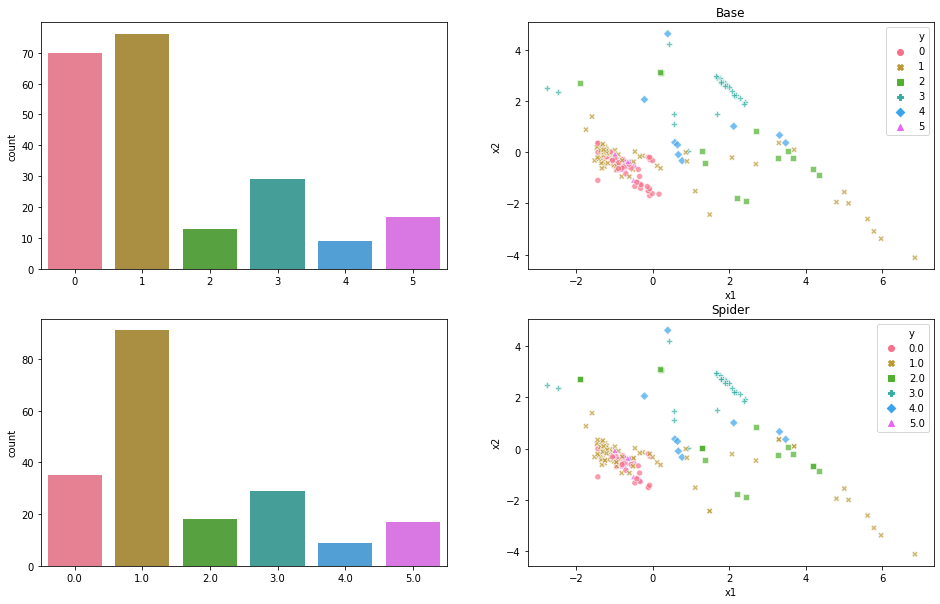

In [8]:


def construct_flat_2pc_df(X, y) -> pd.DataFrame:
    y = pd.DataFrame({'y': y})
    X_df = pd.DataFrame(data=X, columns=['x1', 'x2'])

    df = pd.concat([X_df, y], axis=1)
    return df

dataset = load_datasets()['glass']

X, y = dataset.data, dataset.target

cost = calc_cost_matrix('glass')
clf = SPIDER3(k=5, cost=cost, majority_classes=maj_int_min[dataset_name]['maj'], intermediate_classes=maj_int_min[dataset_name]['int'], minority_classes=maj_int_min[dataset_name]['min'])
resampled_X, resampled_y = clf.fit_transform(X, y)

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches( 16, 10)
axs = axs.flatten()

axs[1].set_title("Base")
sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)


axs[3].set_title("Spider")
sns.countplot(resampled_y, ax=axs[2],palette=p)
resampled_X = pca.transform(resampled_X)
df = construct_flat_2pc_df(resampled_X, resampled_y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[3], legend='full', palette=p)